**Date:** 16th of May, 2025

# Skin Cancer Detection - CNN vs. SVM for Image Classification

***Machine Learning & Deep Learning***

**Professor**: Somnath Mazumdar

**Authors:**

- Daconto Michele - 176193

- Alessio Desideri - 176184

The project involves the creation and optimization of machine-learning models, specifically CNNs (*Convolutional Neural Networks*) and SVMs (*Support Vector Machines*), to recognize skin cancers (*melanoma*) from dermoscopic images. Relying solely on the images, without additional features, the goal of our research was to maximize the models' performance and compare them with one another.

## Get Images and Metadata

You can download the images and metadata (***ISIC-Images.zip***) [here](https://www.dropbox.com/scl/fi/tlnk9ye0nwynjy86p2qs2/ISIC-images.zip?rlkey=u3njwxa518xk5q1subqqgvi8q&st=lk02ewpz&dl=0).

Uncomment and change the directories in the next cell if you need to extract images and metadata from the ZIP.

In [ ]:
"""
import os
import zipfile
from tqdm import tqdm

def extract_images(zip_path, output_dir = "skin_images"):
    # Create the destination folder, if it doesn't exist
    os.makedirs(output_dir, exist_ok = True)
    # Open ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        total_files = len(members)
        # Iterate and extract files
        for member in tqdm(members, total = total_files, desc = "Extraction"):
            zip_ref.extract(member, output_dir)

    print(f"All {total_files} files were extracted into'{output_dir}'.")

if __name__ == "__main__":
    extract_images("ISIC-images.zip")
"""

## Padding & Resizing

Uncomment and change directories in the next cell if you need to ***resize and pad*** each image.

Padding consists of making each image square by filling the borders with black bands. Once the image is square, it can be resized without concern for any distortions.


In [ ]:
"""
import os
import tensorflow as tf
from tqdm import tqdm

# Parameters
INPUT_DIR = "skin_images"
OUTPUT_DIR = "skin_resized"
FINAL_SIZE = 224  # We want images to be 224 x 224
PAD_COLOR = 0  # Black padding

# Destination folder
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Decode images in 3 channels
def load_rgba_image(path):
    file_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(
        file_bytes,
        channels = 3, # Force 3 channels (RGB)
    )
    return tf.cast(img, tf.uint8)

# To not distorce images, pad them first into a squared form and then resize
def pad_and_resize_tf(image, size, fill_value):
    # Dimensions of an image
    shape = tf.shape(image)
    h, w = shape[0], shape[1]
    max_side = tf.maximum(h, w)
    # Padding measures
    pad_h = max_side - h
    pad_w = max_side - w
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    paddings = [
        [pad_top, pad_bottom],
        [pad_left, pad_right],
        [0, 0]
    ]
    # Make the image a square
    image_padded = tf.pad(
        image,
        paddings = paddings,
        mode = "CONSTANT",
        constant_values = fill_value
    )
    # Make it 224 x 224
    image_resized = tf.image.resize(
        image_padded,
        [size, size],
        method = tf.image.ResizeMethod.BILINEAR
    )
    # Return it encoded
    return tf.cast(image_resized, tf.uint8)

# Iterate on every image
for fname in tqdm(os.listdir(INPUT_DIR), desc = "Padding + Resizing"):
    # Skip if it's not a .jpg file
    if not fname.lower().endswith((".jpg")):
        continue
    in_path  = os.path.join(INPUT_DIR, fname)
    out_path = os.path.join(OUTPUT_DIR, fname)
    try:
        # Decode .jpg file
        img = load_rgba_image(in_path)
    # Skip corrupted files which can't be read
    except tf.errors.InvalidArgumentError as e:
        print(f"Skipping {fname}: {e}")
        continue

    # Pad and Resize each image
    out_img = pad_and_resize_tf(img, FINAL_SIZE, PAD_COLOR)

    # Save them
    out_png = tf.io.encode_png(out_img)
    tf.io.write_file(out_path, out_png)
"""


# Data Pre-Processing & EDA

In this section, we prepare the data for the modeling that will follow. Specifically, we balance the classes to avoid creating biased models: since the dataset originally contained 17,940 malignant cancer images and 10,965 benign, ***undersampling*** was applied to reduce malignant images to 10,965.

We then add a boolean column called *Label*, where 0 represents benign cancer and 1 malignant.

Next, we ensure that the dataset can access the images through the correct path specified in the *Index* column.

Uncomment the next cellif you need to install those libraries.

In [ ]:
# pip install numpy pandas pillow matplotlib tqdm tensorflow scikit-learn

In [ ]:
# Import libraries
import os
import random
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV as _GridSearchCV, ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# Ensure reproducibility
random.seed(77)
np.random.seed(77)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set dataset paths
data_dir = '/content/drive/MyDrive/skin_resized'
csv_path = '/content/drive/MyDrive/metadata.csv'

# Load metadata
df = pd.read_csv(csv_path)

# See few lines
df.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,anatom_site_special,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,...,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,sex
0,ISIC_0000002,Anonymous,CC-0,NaN,60.0,upper extremity,NaN,malignant,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,female
1,ISIC_0000004,Anonymous,CC-0,NaN,80.0,posterior torso,NaN,malignant,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,male
2,ISIC_0000013,Anonymous,CC-0,NaN,30.0,posterior torso,NaN,malignant,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,female
3,ISIC_0000022,Anonymous,CC-0,NaN,55.0,lower extremity,NaN,malignant,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,female
4,ISIC_0000026,Anonymous,CC-0,NaN,30.0,lower extremity,NaN,malignant,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,female


In [ ]:
# We are only interested in images indexes and diagnosis
df = df[["isic_id", "diagnosis_1"]]

# Rename columns
df = df.rename(columns = {"isic_id": "Image_ID", "diagnosis_1": "Diagnosis"})

# "Index" column should be the exact filename
df["Image_ID"] = df["Image_ID"] + ".jpg"

# Check
df.head()

,Image_ID,Diagnosis
0,ISIC_0000002.jpg,Malignant
1,ISIC_0000004.jpg,Malignant
2,ISIC_0000013.jpg,Malignant
3,ISIC_0000022.jpg,Malignant
4,ISIC_0000026.jpg,Malignant


In [ ]:
# Look for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28905 entries, 0 to 28904
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Image_ID   28905 non-null  object
 1   Diagnosis  28905 non-null  object
dtypes: object(2)
memory usage: 451.8+ KB


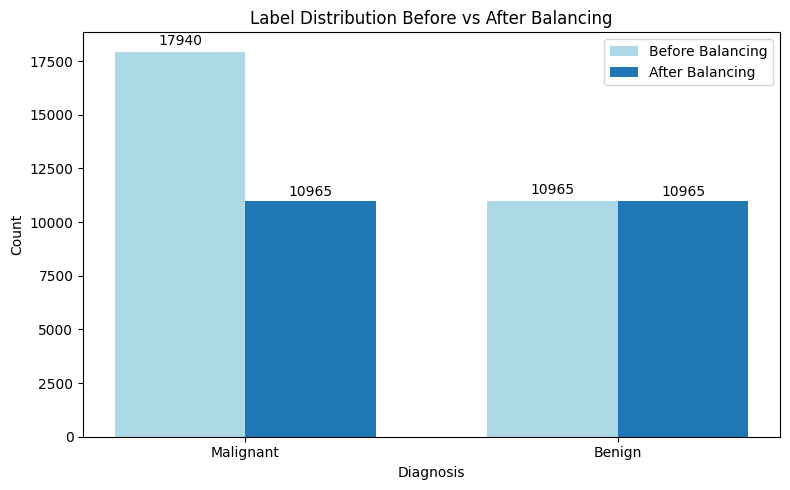

In [ ]:
# Check label distribution
original_distribution = df["Diagnosis"].value_counts()

# Adjust
benign_count = df["Diagnosis"].value_counts().get("Benign", 0)

# Balanced df
df = pd.concat([
    df[df["Diagnosis"] == "Malignant"].sample(benign_count),  # Undersampling majority class ("Malignant")
    df[df["Diagnosis"] == "Benign"]
], ignore_index = True)

# Shuffle and reset index
df = df.sample(frac = 1).reset_index(drop = True)

# Graphic check
balanced_distribution = df["Diagnosis"].value_counts()
categories = original_distribution.index.tolist()
orig_vals = original_distribution.values
bal_vals  = balanced_distribution.reindex(categories).values
x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots(figsize = (8, 5))

# Original bars (light turqouise)
ax.bar(x - width/2, orig_vals, width,
       label = "Before Balancing",
       color = "#add8e6")

# Balanced bars (dark blue)
ax.bar(x + width/2, bal_vals, width,
       label = "After Balancing",
       color = "#1f77b4")

# Label and Title
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Count")
ax.set_title("Label Distribution Before vs After Balancing")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display percentages above bars
for xpos, val in zip(x - width / 2, orig_vals):
    ax.text(xpos, val + max(orig_vals) * 0.01, str(val), ha = "center", va = "bottom")
for xpos, val in zip(x + width / 2, bal_vals):
    ax.text(xpos, val + max(bal_vals) * 0.01, str(val), ha = "center", va = "bottom")

plt.tight_layout()
plt.show()

In [ ]:
# Make labels boolean
df["Label"] = df["Diagnosis"].apply(lambda s: 0 if s == "Benign" else 1)

# Shuffle and check
df = df.sample(frac = 1).reset_index(drop = True)
df.head(10)

,Image_ID,Diagnosis,Label
0,ISIC_0063445.jpg,Malignant,1
1,ISIC_0022315.jpg,Malignant,1
2,ISIC_3232113.jpg,Benign,0
3,ISIC_6375742.jpg,Benign,0
4,ISIC_0033646.jpg,Benign,0
5,ISIC_0059350.jpg,Malignant,1
6,ISIC_0026015.jpg,Benign,0
7,ISIC_1218102.jpg,Benign,0
8,ISIC_4127692.jpg,Benign,0
9,ISIC_4448776.jpg,Benign,0


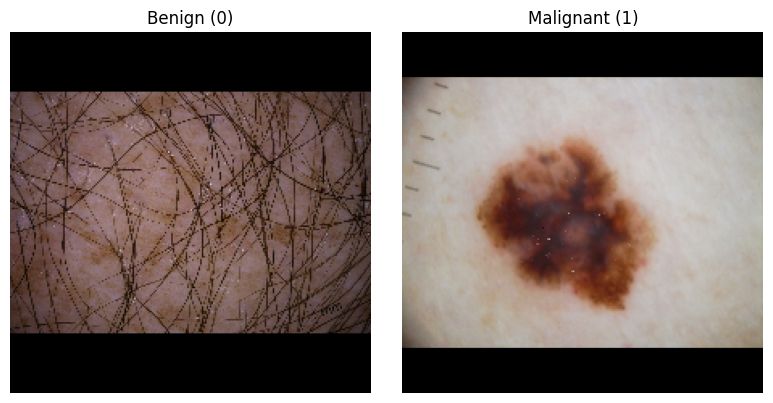

In [ ]:
# Show one example image per class

# Assuming df already has 'image_id' (filename) and 'label' (0 = Benign, 1 = Malignant)
df0 = df[df["Diagnosis"] == "Benign"]
df1 = df[df["Diagnosis"] == "Malignant"]

# Sample one random entry from each class
img0_name = df0.sample(1, random_state = 42).iloc[0]["Image_ID"]
img1_name = df1.sample(1, random_state = 42).iloc[0]["Image_ID"]

# Build full paths
path0 = os.path.join(data_dir, img0_name)
path1 = os.path.join(data_dir, img1_name)

# Load images
img0 = Image.open(path0)
img1 = Image.open(path1)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].imshow(img0)
axes[0].set_title("Benign (0)")
axes[0].axis("off")
axes[1].imshow(img1)
axes[1].set_title("Malignant (1)")
axes[1].axis("off")
plt.tight_layout()
plt.show()


The black bands are the result of the previously applied padding.

## Split into Train, Validation & Test Sets

Here we split our 21,930 labeled images into Train set (70%), Validation set (15%) and Test set (15%).

Train set: 15351 samples (70.0%)
Validation set: 3289 samples (15.0%)
Test set: 3290 samples (15.0%)


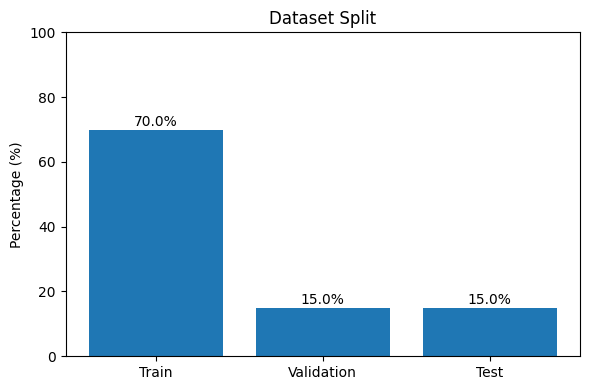

In [ ]:
# Split
train_df, temp_df = train_test_split(df, test_size = 0.30, stratify = df["Label"], random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size = 0.50, stratify = temp_df["Label"], random_state = 42)

# Check
n_total = len(df)
print(f"Train set: {len(train_df)} samples ({len(train_df)/n_total:.1%})")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/n_total:.1%})")
print(f"Test set: {len(test_df)} samples ({len(test_df)/n_total:.1%})")

# Graphic Check
percentages = {
    "Train": len(train_df) / n_total * 100,
    "Validation": len(val_df) / n_total * 100,
    "Test": len(test_df) / n_total * 100
}
labels = list(percentages.keys())
values = list(percentages.values())

plt.figure(figsize = (6, 4))
plt.bar(labels, values)
plt.ylim(0, 100)

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha = "center")
plt.title("Dataset Split")
plt.ylabel("Percentage (%)")
plt.tight_layout()
plt.show()

### Augmentation

Regarding the training set, we decided to apply image ***augmentation*** to help the models generalize better. The augmentation techniques applied are:

- Horizontal flip on half of the images → creates a *mirror* image of the original
- Random rotation of ± 60°
- Random zoom  ± 10% → slightly increases or decreases the image brightness
- Random conntrast (0.1) → changes the contrast between colors

Augmentation was not applied to the images in the validation and test sets, as we want to evaluate the predictions on the original images.

In [ ]:
# Augmentation parameters
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.6),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

### Building Train, Validation & Test Datasets on TensorFlow

In [ ]:
# Function to create a TensorFlow subset of a df
def make_dataset(df, batch_size = 32, shuffle = True, augment = False):
    paths = df["Image_ID"].apply(lambda x: os.path.join(data_dir, x)).values
    labels = df["Label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(paths))
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels = 3)  # RGB
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [224, 224])
        if augment:  # Will be used only on Training set
            img = data_augmentation(img)
        return img, label
    ds = ds.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Use the function to create the Train, Validation and Test sets on TensorFlow
batch_size = 32
train_ds = make_dataset(train_df, batch_size = batch_size, shuffle = True, augment = False)  # Will be applied during training, not now
val_ds = make_dataset(val_df, batch_size = batch_size, shuffle = False, augment = False)
test_ds = make_dataset(test_df, batch_size = batch_size, shuffle = False, augment = False)

### Augmented vs. Non-Augmented

See the effects of augmentation on the 4 images we printed.

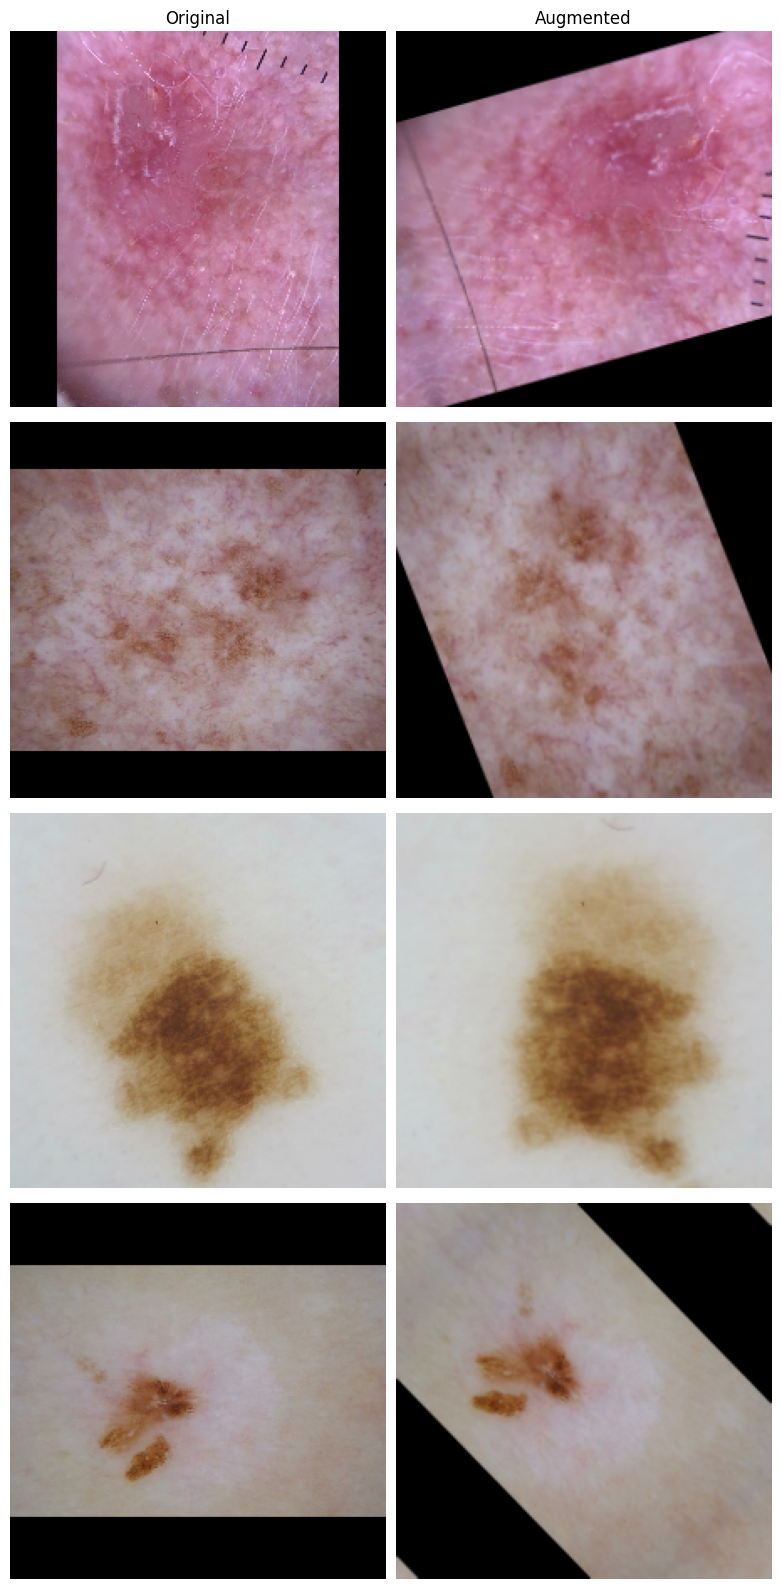

In [ ]:
# Take 4 random images from df
sample_ids = train_df.sample(4, random_state = 42)["Image_ID"].values

# Plot
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 16))

# Display each original image and its augmented version side-by-side
for i, img_id in enumerate(sample_ids):
    path = os.path.join(data_dir, img_id)

    # Load and preprocess the original image
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])

    # Augment it
    img_aug = data_augmentation(tf.expand_dims(img, 0), training = True)[0]

    # Plot the original
    axes[i, 0].imshow(img.numpy())
    axes[i, 0].axis("off")
    if i == 0:
        axes[i, 0].set_title("Original")

    # Plot the augmented
    axes[i, 1].imshow(img_aug.numpy())
    axes[i, 1].axis("off")
    if i == 0:
        axes[i, 1].set_title("Augmented")

plt.tight_layout()
plt.show()

# Journey to SkinNET80

The final CNN model we came up with, ***SkinNET80***, is the result of many hours spent on optimization and testing various CNNs with diverse features.

The main checkpoints of our *ensembling* process are discussed below.

## 1st Model - Basic CNN (two layers)

We started from nearly the simplest CNN structure possible, with two convolutional layers and:
- *Adam* as the weight update algorithm (***how*** the model learns);
- *Binary Cross Entropy* and *Accuracy* as the metrics the model should optimize (***what*** the model should work on).

### Architecture

In [ ]:
# Build
def build_CNN_1(input_shape):
    inputs = layers.Input(shape = input_shape)

    # 1st Layer
    x = layers.Conv2D(32, (3, 3), activation = "relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # 2nd Layer
    x = layers.Conv2D(64, (3, 3), activation = "relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation = "relu")(x)
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    return Model(inputs, outputs)

# Assign model
model_1 = build_CNN_1((224, 224, 3))

# Compile
model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

# Check architecture
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history_1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,  # 20 epochs
)

Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 409s 841ms/step - accuracy: 0.7205 - loss: 0.6649 - val_accuracy: 0.7522 - val_loss: 0.4887
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7670 - loss: 0.4673 - val_accuracy: 0.7677 - val_loss: 0.4774
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7839 - loss: 0.4402 - val_accuracy: 0.7981 - val_loss: 0.4104
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7871 - loss: 0.4200 - val_accuracy: 0.8036 - val_loss: 0.4173
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8077 - loss: 0.3912 - val_accuracy: 0.8057 - val_loss: 0.4162
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8250 - loss: 0.3673 - val_accuracy: 0.7923 - val_loss: 0.4425
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.8292 - loss: 0.3549 - val_accuracy: 0.7966 - val_loss: 0.4517
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.8379 - loss: 0.3362 

### Overfitting/Underfitting Issues

Being too simple and basic, this model ended up ***heavily overfitting*** and thus is unable to generalize. By epoch 20, it reached a training accuracy of 98% and a validation accuracy of 79%.

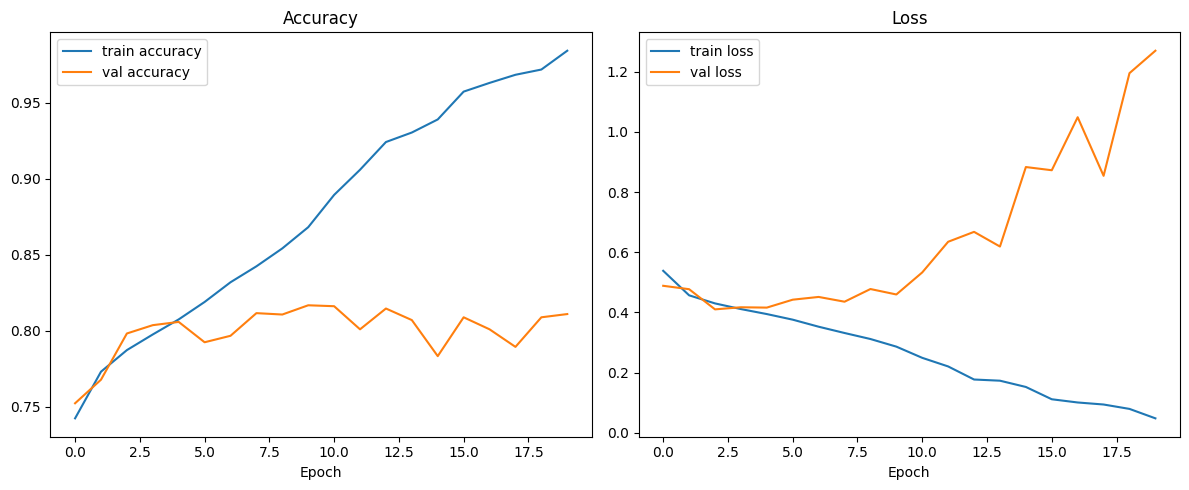

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Accuracy
axes[0].plot(history_1.history["accuracy"], label = "train accuracy")
axes[0].plot(history_1.history["val_accuracy"], label = "val accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].legend()

# Loss
axes[1].plot(history_1.history["loss"], label = "train loss")
axes[1].plot(history_1.history["val_loss"], label = "val loss")
axes[1].set_title("Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

## 2nd Model - CNN with Dropout and Class weights

We re-elaborated the first model by adding two convolutional layers. To prevent it from overfitting, we add the **dropout** just before the output layer to randomly "turn off" 30% of the neurons. Further, to reduce the number of false negatives we added the *class_weights* parameter when training.

We then improved the model by including callbacks to let it adjust itself autonomously during training:
- *Early Stopping*, which halts training if the validation loss doesn't improve after 5 epochs. Once training stops, it restores the weights that achieved the best performance;
- *Reduce LR on Plateau*, which ensures the learning rate doesn't stay too high by halving the learning rate if the *val_loss* doesn't improve for 3 consecutive epochs.

### Architecture

In [ ]:
# Build
def build_CNN_2(input_shape):
    inputs = layers.Input(shape = input_shape)
    x = inputs

    # 1st Layer
    x = layers.Conv2D(32, (3, 3), activation = "relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 2nd Layer
    x = layers.Conv2D(64, (3, 3), activation = "relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 3rd Layer
    x = layers.Conv2D(128, (3, 3), activation = "relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 4th Layer
    x = layers.Conv2D(256, (3, 3), activation = "relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)  # Help to reduce overfitting
    outputs = layers.Dense(1, activation = "sigmoid")(x)  # Binary output (0, 1)

    return Model(inputs, outputs)

# Assign model
model_2 = build_CNN_2((224, 224, 3))

# Compile
model_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

# Set Early Stopping -> Stop training if val_loss doesn't get better after 5 epochs
earlystop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,  # Threshold
    restore_best_weights = True  # Restore best weights after the training
)

# Monitor Learning Rate -> Reduce it of 0.5 if val_loss doesn't get better after 3 epochs
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = "val_loss",  # Metric to monitor
    factor = 0.5, # Factor of reduction
    patience = 3,  # Threshold
    verbose = 1,
    min_lr = 1e-6   # Minimum reachable
)

# Check architecture
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,113 (37.48 MB)

 Trainable params: 9,826,113 (37.48 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
# Finally Training
history_2 = model_2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = [earlystop, reduce_lr], # New
    class_weight = {0: 1.0, 1: 1.2}  # New -> to reduce false negatives
)

Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.7075 - loss: 0.6299 - val_accuracy: 0.7711 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.7752 - loss: 0.4982 - val_accuracy: 0.7887 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7872 - loss: 0.4695 - val_accuracy: 0.7911 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7888 - loss: 0.4622 - val_accuracy: 0.7972 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7999 - loss: 0.4501 - val_accuracy: 0.8060 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8105 - loss: 0.4191 - val_accuracy: 0.8103 - val_loss: 0.3897 - learning_rate: 0.0010
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8115 - l

The training was stopped by EarlyStopping as the *val_loss* didn't get better after five consecutive epochs. The metrics are quite good, but the structure has to be improved further.

### Overfitting/Underfitting Issues

The model is still prone to overfitting, as the validation and train metrics are far from being aligned.

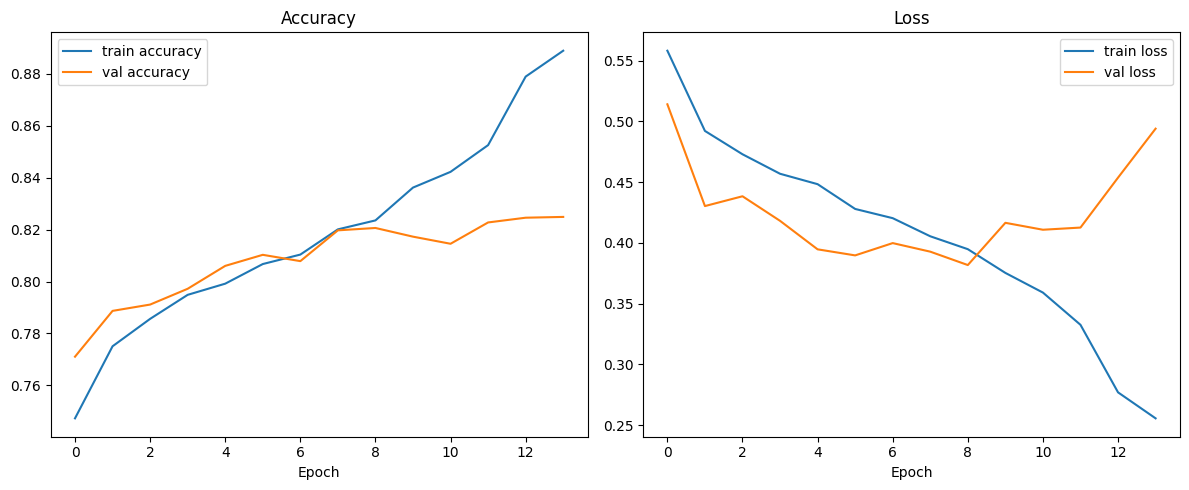

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Accuracy
axes[0].plot(history_2.history["accuracy"], label = "train accuracy")
axes[0].plot(history_2.history["val_accuracy"], label = "val accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].legend()

# Loss
axes[1].plot(history_2.history["loss"], label = "train loss")
axes[1].plot(history_2.history["val_loss"], label = "val loss")
axes[1].set_title("Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

## SkinNET80 - with BatchNormalization & Increased Dropout

To help the model generalize better we increased Dropout from 0.3 to 0.5 and reduced the layers from 4 to 3. We then decided to add *BatchNormalization* on every layer as it's suggested for enhancing convergence and to keep the *class_weights* parameter when training.

### Architecture

In [ ]:
# Build
def build_CNN_3(input_shape):
    inputs = layers.Input(shape = input_shape)

    # 1st Layer
    x = layers.Conv2D(32, (3, 3), activation = "relu")(inputs)
    x = layers.BatchNormalization()(x)  # New
    x = layers.MaxPooling2D((2, 2))(x)

    # 2nd Layer
    x = layers.Conv2D(64, (3, 3), activation = "relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 3rd Layer
    x = layers.Conv2D(128, (3, 3), activation = "relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation = "relu")(x)
    x = layers.Dropout(0.5)(x)  # New -> Help to reduce overfitting
    outputs = layers.Dense(1, activation = "sigmoid")(x)  # Binary output (0, 1)
    return Model(inputs, outputs)

# Assign model
model_3 = build_CNN_3((224, 224, 3))

# Compile
model_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

# Check architecture
model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

### Training

In [ ]:
# Start stopwatch
start_time = time.time()

# Train
history_3 = model_3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    class_weight = {0: 1.0, 1: 1.2}
)

# Stop stopwatch
end_time = time.time()
execution_final_cnn = end_time - start_time
print(f"Execution time: {execution_final_cnn:.2f} seconds")

Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.6913 - loss: 4.6524 - val_accuracy: 0.7251 - val_loss: 0.5763
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7384 - loss: 0.6017 - val_accuracy: 0.6424 - val_loss: 0.7753
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7452 - loss: 0.5822 - val_accuracy: 0.7452 - val_loss: 0.5604
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.7467 - loss: 0.5843 - val_accuracy: 0.7431 - val_loss: 0.4915
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7441 - loss: 0.5677 - val_accuracy: 0.7455 - val_loss: 0.4812
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7448 - loss: 0.5535 - val_accuracy: 0.7452 - val_loss: 0.6374
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7523 - loss: 0.5797 - val_accuracy: 0.7352 - val_loss: 0.4914
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.7415 - loss: 0.5568 - 

### Overfitting/Underfitting Issues

This CNN looks way more reliable: it does not suffer from overfitting problems and has acceptable metrics.

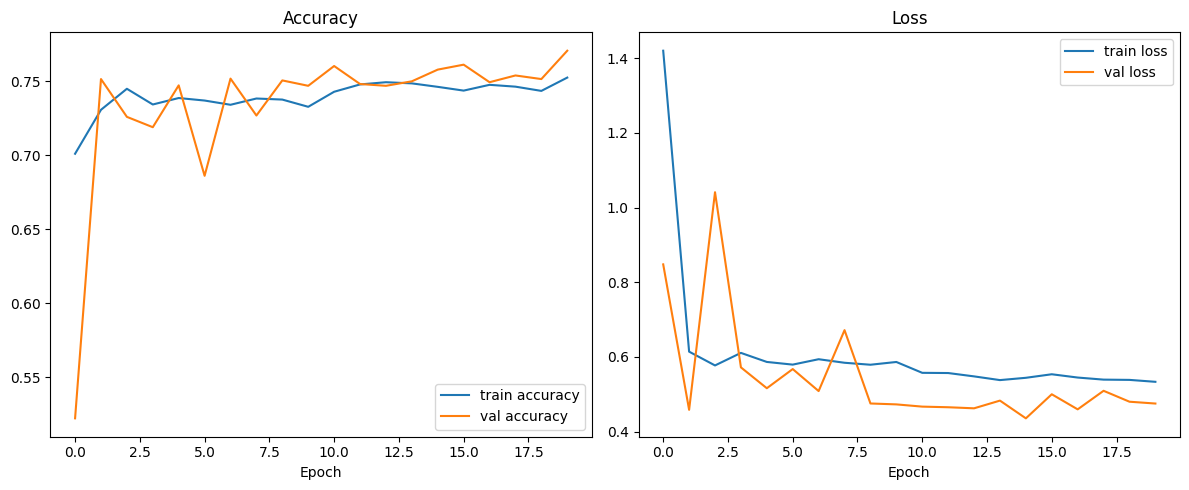

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Accuracy
axes[0].plot(history_3.history["accuracy"], label = "train accuracy")
axes[0].plot(history_3.history["val_accuracy"], label = "val accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].legend()

# Loss
axes[1].plot(history_3.history["loss"], label = "train loss")
axes[1].plot(history_3.history["val_loss"], label = "val loss")
axes[1].set_title("Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

### Evaluation on Test Set

In [ ]:
# Take probabilities from the model
y_prob = model_3.predict(test_ds)

# 0.5 threshold for binary outputs
y_pred = (y_prob.flatten() >= 0.5).astype(int)

# Take true labels from Test set
y_true = np.concatenate([y for _, y in test_ds], axis = 0)

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names = ["Benignant", "Malignant"]
))

103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 676ms/step

Classification Report:
              precision    recall  f1-score   support

   Benignant       0.70      0.91      0.79      1645
   Malignant       0.87      0.62      0.72      1645

    accuracy                           0.76      3290
   macro avg       0.79      0.76      0.76      3290
weighted avg       0.79      0.76      0.76      3290



Once we’ve studied loss and accuracy values, we further evaluate the model using the **Confusion Matrix** and the **ROC-AUC Curve**.

The *Confusion Matrix* is especially useful for identifying false positives and false negatives. The model seems to struggle with false negatives... the *class_weights* parameter seems to not have helped us much.

The *ROC-AUC* (*Receiver Operating Characteristic – Area Under Curve*) focuses on the trade-off between false positives and true positives. The closer the area under the curve is to 1, the better the model is at separating the two classes. In other words, the more curved and elevated the graph, the more accurate the classifier. The dashed orange line represents the performance of a random classifier (AUC: 0.5).

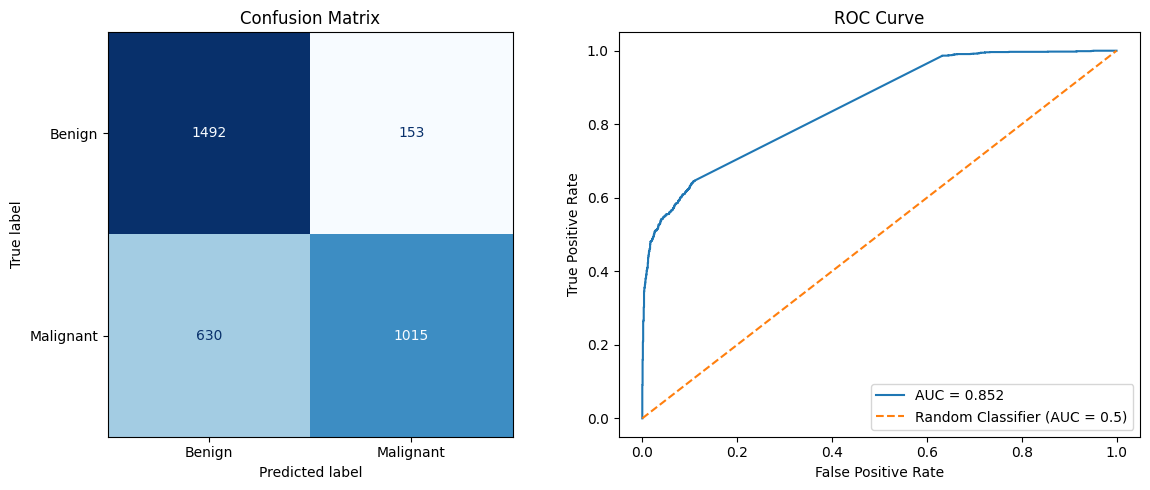

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Benign", "Malignant"])

# ROC–AUC Curve
y_score = y_prob.ravel()
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# Display Confusion Matrix
disp_cm.plot(ax = ax1, cmap = plt.cm.Blues, colorbar = False)
ax1.set_title("Confusion Matrix")

# Display ROC curve
ax2.plot(fpr, tpr, label = f"AUC = {roc_auc:.3f}")
ax2.plot([0, 1], [0, 1], linestyle = "--", label = "Random Classifier (AUC = 0.5)")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend()
plt.tight_layout()
plt.show()

# SVM - Approach end-to-end

Now it's the moment to test the capabilities of classification of a **SVM (*Support Vector Machine*)** model, where the inputs are just images in the form of vectors (with standardized values).

We applied *PCA (99% variance explained)* to accelerate the process because the number of features inside each vector is huge.

In [ ]:
# Start stopwatch
start_time = time.time()

# Function to flatten tf.data.Dataset into feature arrays
def ds_to_flat_arrays(ds):
    imgs_list, labels_list = [], []
    n_batches = tf.data.experimental.cardinality(ds).numpy()
    ds_iter = iter(ds)
    for _ in tqdm(range(n_batches), desc = "Flattening images..."):  # Progress bar
        imgs, labels = next(ds_iter)
        flat = tf.reshape(imgs, [imgs.shape[0], -1]).numpy()
        imgs_list.append(flat)
        labels_list.append(labels.numpy())
    X = np.vstack(imgs_list)
    y = np.concatenate(labels_list)
    return X, y

# Turn sets into arrays
X_train, y_train = ds_to_flat_arrays(train_ds)
X_val, y_val = ds_to_flat_arrays(val_ds)
X_test, y_test = ds_to_flat_arrays(test_ds)
print(f"Images flattening took {time.time() - start_time:.1f}s")

# Standardize vectors' values (features)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
print(f"Dim. before PCA: Train = {X_train_s.shape[1]} features")

# Obtain number of most important features (using 99% PCA on a random sample of 2,000)
sample_idx = np.random.choice(X_train_s.shape[0], size = 2000, replace = False)
pca_sample = PCA(n_components = 0.99, svd_solver = "full", random_state = 42)
pca_sample.fit(X_train_s[sample_idx])
n_comp = pca_sample.n_components_
print(f"Estimated n_components for 99% variance: {n_comp}")

# Full PCA with randomized solver & determined n_components
pca = PCA(
    n_components = n_comp,
    svd_solver = "randomized",
    random_state = 42,
    iterated_power = 3
)

# Apply PCA to arrays we built before
X_train_pca = pca.fit_transform(X_train_s)
X_val_pca = pca.transform(X_val_s)
X_test_pca = pca.transform(X_test_s)
print(f"Dim. after PCA: Train = {X_train_pca.shape[1]} features")

# Grid search SVM on Training set
param_grid = {
    "C": [1, 10],  # Regularization Parameter
    "gamma": ["scale"],
    "kernel": ["rbf"]  # Radial Basis Function
}
svm = SVC(probability = True, class_weight = "balanced")

class GridSearchCVProgress(_GridSearchCV):
    def _run_search(self, evaluate_candidates):
        for params in tqdm(list(ParameterGrid(self.param_grid)), desc = "Grid search progress"):  # Progress bar
            evaluate_candidates([params])

grid = GridSearchCVProgress(
    estimator = svm,
    param_grid = param_grid,
    cv = 3,
    scoring = "roc_auc",
    n_jobs = -1,
    verbose = 1
)

# Begin the search for optimal params
grid.fit(X_train_pca, y_train)

# Stop stopwatch
end_time = time.time()
svm_pure_time = end_time - start_time

# Best parameters
print("Best SVM params:", grid.best_params_)

# Evaluate on Test set
y_pred = grid.predict(X_test_pca)
print("\nTest set classification report:")
print(classification_report(y_test, y_pred, target_names = ["Benign", "Malignant"]))


Flattening images...: 100%|██████████| 103/103 [00:03<00:00, 26.62it/s]


Images flattening took 31.1s
Dim. before PCA: Train = 150528 features
Estimated n_components for 99% variance: 670
Dim. after PCA: Train = 670 features


Grid search progress:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Grid search progress:  50%|█████     | 1/2 [03:15<03:15, 195.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Grid search progress: 100%|██████████| 2/2 [06:26<00:00, 193.31s/it]


Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Test set classification report:
              precision    recall  f1-score   support

      Benign       0.81      0.84      0.83      1645
   Malignant       0.83      0.81      0.82      1645

    accuracy                           0.82      3290
   macro avg       0.82      0.82      0.82      3290
weighted avg       0.82      0.82      0.82      3290



### Over/Under Fitting Issues

In [ ]:
# Training set
y_train_pred = grid.predict(X_train_pca)
y_train_prob = grid.predict_proba(X_train_pca)[:, 1]
print("Training Set Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC : {roc_auc_score(y_train, y_train_prob):.4f}")
print(classification_report(y_train, y_train_pred, target_names = ["Benign", "Malignant"]))

# Validation set
y_val_pred  = grid.predict(X_val_pca)
y_val_prob  = grid.predict_proba(X_val_pca)[:, 1]
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"ROC AUC : {roc_auc_score(y_val, y_val_prob):.4f}")
print(classification_report(y_val, y_val_pred, target_names = ["Benign", "Malignant"]))


Training Set Metrics:
  Accuracy: 0.9173
  ROC AUC : 0.9762
              precision    recall  f1-score   support

      Benign       0.90      0.93      0.92      7675
   Malignant       0.93      0.90      0.92      7676

    accuracy                           0.92     15351
   macro avg       0.92      0.92      0.92     15351
weighted avg       0.92      0.92      0.92     15351

Validation Set Metrics:
  Accuracy: 0.8234
  ROC AUC : 0.9066
              precision    recall  f1-score   support

      Benign       0.80      0.86      0.83      1645
   Malignant       0.85      0.79      0.82      1644

    accuracy                           0.82      3289
   macro avg       0.82      0.82      0.82      3289
weighted avg       0.82      0.82      0.82      3289



The SVM model is slightly overfitting, as the validation metrics are worse than the training ones.

In [ ]:
print(f"Feature‐SVM pipeline time: {svm_pure_time:.1f}s")

Feature‐SVM pipeline time: 961.1s


### Confusion Matrix & ROC-AUC Curve

Here the results are satisfying. The model is very solid when it comes to false positives and false negatives errors. Though, it would have been better if the model made less errors on the latters.

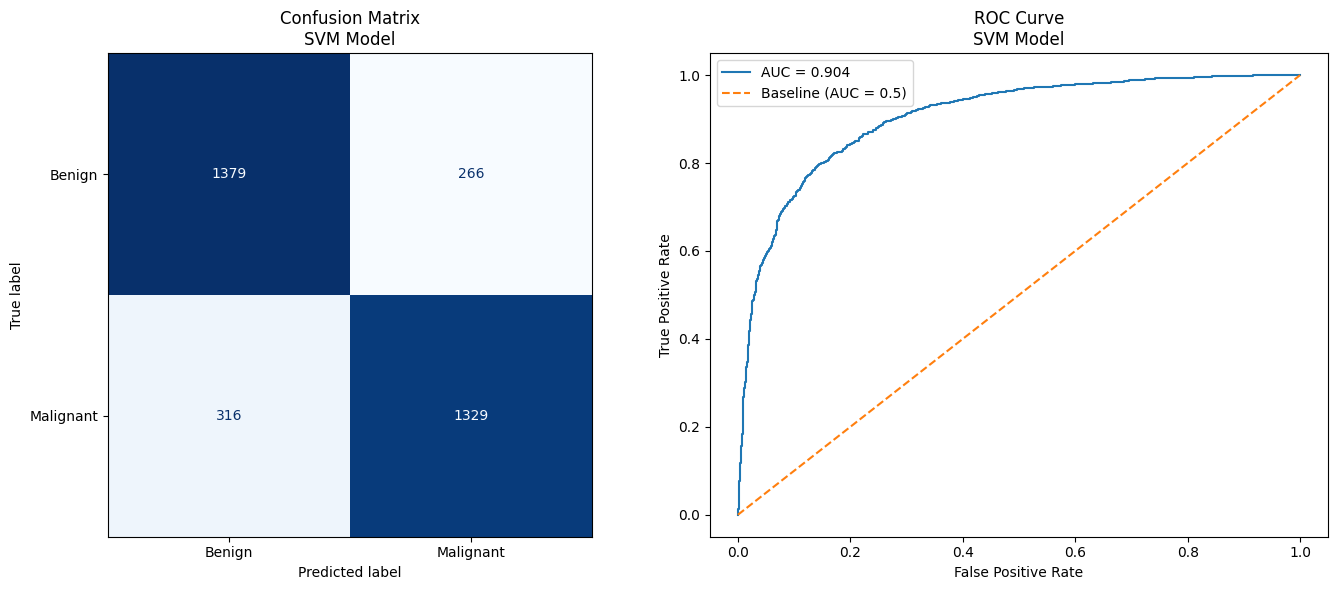

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Benign", "Malignant"])

# ROC–AUC Curve
y_score = grid.decision_function(X_test_pca)  # Continuous
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# Confusion Matrix sul primo ax
disp_cm.plot(ax = ax1, cmap = plt.cm.Blues, colorbar = False)
ax1.set_title("Confusion Matrix\nSVM Model")

# ROC curve sul secondo ax
ax2.plot(fpr, tpr, label = f"AUC = {roc_auc:.3f}")
ax2.plot([0, 1], [0, 1], linestyle = "--", label = "Baseline (AUC = 0.5)")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve\nSVM Model")
ax2.legend()

plt.tight_layout()
plt.show()

# CNN + SVM - Hybrid Approach

Finally, we use SVM as a final classifier for the parameters from the *dense* layer of the CNN. This layer includes 256 parameters and is the second-to-last right before the dropout and output. We were curious to try this approach because other studies have used it and seemed to obtain a good performance.

In [ ]:
# Start stopwatch
start_time = time.time()

# Locate the Dense layer (3rd from last) of SkinNET80 (model_3)
target_layer = model_3.layers[-3]

# Build a feature‐extractor model
feature_extractor = Model(
    inputs = model_3.input,
    outputs = target_layer.output,
    name = "dense_feature_extractor"
)

# Function to extract features from a TensorFlow dataset
def extract_features(ds):
    feats_list, labels_list = [], []
    n_batches = tf.data.experimental.cardinality(ds).numpy()
    ds_iter   = iter(ds)
    for _ in tqdm(range(n_batches), desc = "Extracting features"):
        imgs, labels = next(ds_iter)
        feats = feature_extractor.predict(imgs, verbose = 0)
        feats_list.append(feats)
        labels_list.append(labels.numpy())
    X = np.vstack(feats_list)
    y = np.concatenate(labels_list)
    return X, y

# Extract features on Train, Val and Test datasets
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

# Standardize feature vectors
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Grid search SVM on features
param_grid = {
    "C": [0.1,1,10],
    "gamma": ["scale","auto"],
    "kernel": ["rbf"]
}

# SVM
svm = SVC(probability = True, class_weight = "balanced")
grid = GridSearchCV(svm, param_grid, cv = 5, scoring = "roc_auc", n_jobs = -1)
grid.fit(X_train_s, y_train)

# Stop stopwatch
end_time = time.time()
svm_hybrid_time = end_time - start_time
print(f"Feature‐SVM pipeline time: {svm_hybrid_time:.1f}s")

# Best parameters
print("Best SVM params:", grid.best_params_)

# Evaluate on Test set
y_pred = grid.predict(X_test_s)
print("\nTest set classification report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))


Extracting features: 100%|██████████| 103/103 [00:09<00:00, 11.25it/s]


Feature‐SVM pipeline time: 962.8s
Best SVM params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Test set classification report:
              precision    recall  f1-score   support

      Benign       0.79      0.84      0.81      1645
   Malignant       0.83      0.78      0.80      1645

    accuracy                           0.81      3290
   macro avg       0.81      0.81      0.81      3290
weighted avg       0.81      0.81      0.81      3290



The performance of this model is slighly better than the CNN's one, but more computationally expensive so our analysis didn't benefit a lot from this approach.

The SVM classifier seems to detect melanoma more effectively than the sigmoid function.

### Confusion Matrix & ROC-AUC Curve

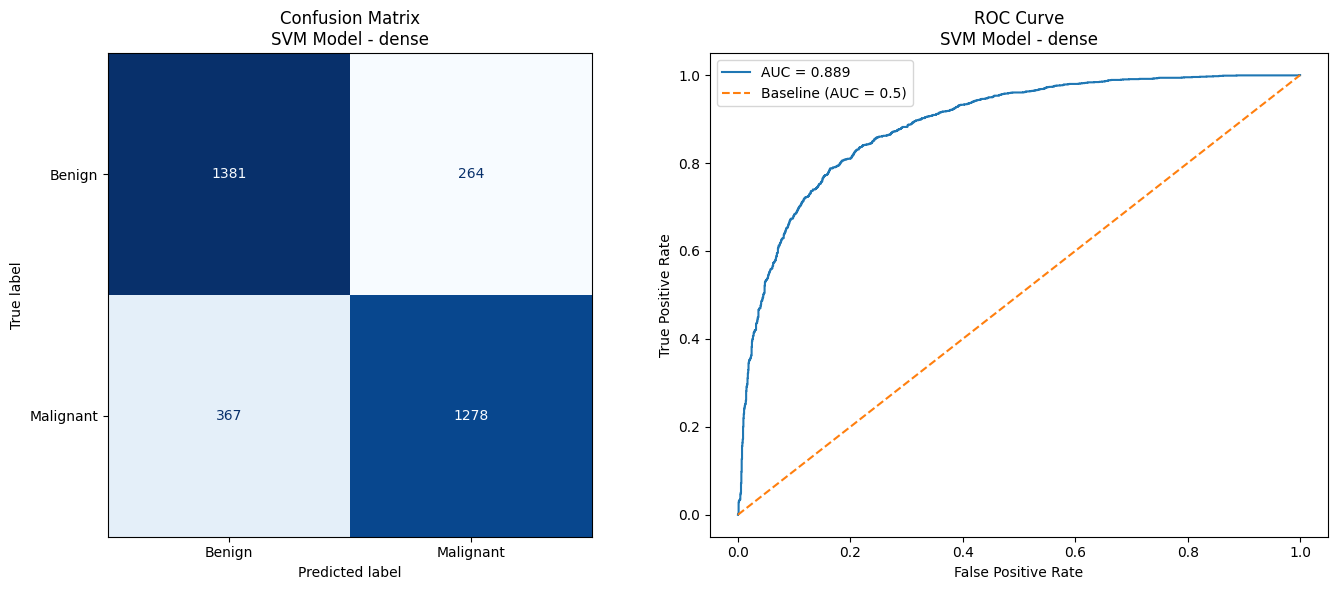

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Benign", "Malignant"])

# ROC–AUC Curve
y_score = grid.decision_function(X_test_s)  # Continuous
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

disp_cm.plot(ax = ax1, cmap = plt.cm.Blues, colorbar = False)
ax1.set_title("Confusion Matrix\nSVM Model - dense")

ax2.plot(fpr, tpr, label = f"AUC = {roc_auc:.3f}")
ax2.plot([0, 1], [0, 1], linestyle = "--", label = "Baseline (AUC = 0.5)")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve\nSVM Model - dense")
ax2.legend()

plt.tight_layout()
plt.show()

# Time Comparison

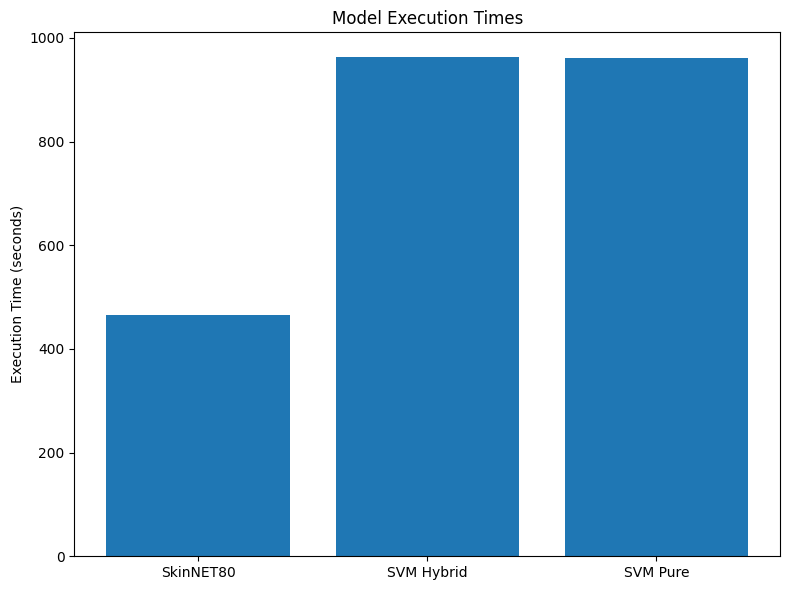

In [ ]:
# Lists with models and respective execution times (in seconds)
models = ["SkinNET80", "SVM Hybrid", "SVM Pure"]
times = [execution_final_cnn, svm_hybrid_time, svm_pure_time,]

# Bar Chart
plt.figure(figsize = (8, 6))
plt.bar(models, times)
plt.ylabel("Execution Time (seconds)")
plt.title("Model Execution Times")
plt.tight_layout()
plt.show()

If we were to pick a best model judging from the trade-off between accuracy and running time, we would choose SkinNET80. Even if it's the model with the lowest accuracy, SkinNET80 takes approximately a half of the time to run compared to the two SVMs.

Though, if you're looking for a more accurate model (which performs bettere especially on False Positives and False Negatives) we recommend you using one of the two SVMs (the Hybrid and Pure approaches have roughly the same performance).